## Language Modeling

In this project, several different types of language models are implemented for text.  We'll start with n-gram models, then move on to neural n-gram and LSTM language models.

The dataset for this project will be the WikiText2 language modeling dataset.  This dataset comes with some of the basic preprocessing, such as tokenization and rare word filtering (using the `<unk>` token).
Therefore, we can assume that all word types in the test set also appear at least once in the training set.
We'll also use the Huggingface `datasets` and `tokenizers` libraries to help with some of the data preprocessing, such as converting tokens into id numbers.

In [1]:

!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.8 MB 7.3 MB/s 
     |████████████████████████████████| 636 kB 44.7 MB/s 
     |████████████████████████████████| 895 kB 56.7 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 3.3 MB 52.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 270 kB 8.2 MB/s 
     |████████████████████████████████| 119 kB 69.0 MB/s 
     |████████████████████████████████| 243 kB 57.8 MB/s 
     |████████████████████████████████| 1.3 MB 55.7 MB/s 
     |████████████████████████████████| 294 kB 74.8 MB/s 
     |████████████████████████████████| 142 kB 67.3 MB/s 


In [2]:
# This block handles some basic setup and data loading.  

from collections import defaultdict, Counter
import numpy as np
import math
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F

# We'll use HuggingFace's datasets and tokenizers libraries.

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import WhitespaceSplit

dataset = load_dataset("wikitext", "wikitext-2-v1")
tokenizer = Tokenizer(WordLevel(unk_token='<unk>'))
tokenizer.pre_tokenizer = WhitespaceSplit() # should be equivalent to split()

# "Training" a tokenizer below just feeds it all the tokens so it can map from
# word type to id.

trainer = WordLevelTrainer( # should only be 33,278 distinct types in Wikitext-2
    vocab_size=33300, special_tokens=["<unk>", "<eos>"])
generator_bsz = 512
all_splits_generator = (dataset[split][i:i+generator_bsz]["text"] 
                        for split in ["train", "validation", "test"] 
                          for i in range (0, len(dataset[split]), generator_bsz))
tokenizer.train_from_iterator(all_splits_generator, trainer)

# If desired, we could make a transformers tokenizer object now with:
# fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)

orig_vocab = tokenizer.get_vocab() # The tokenizer reserves a <pad> id, which we'll ignore.
word_types = sorted(list(orig_vocab.keys()), key=lambda w: orig_vocab[w]) # no <pad>
vocab = {w: i for i, w in enumerate(word_types)} # no <pad>
vocab_size = len(vocab)

# Make a single stream of tokens, with an <eos> after each newline.

train_text = []
for example in dataset["train"]["text"]:
  train_text.extend(tokenizer.encode(example).tokens + ["<eos>"])

validation_text = []
for example in dataset["validation"]["text"]:
  validation_text.extend(tokenizer.encode(example).tokens + ["<eos>"])

print(validation_text[:30])

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.48M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/aa5e094000ec7afeb74c3be92c88313cd6f132d564c7effd961c10fd47c76f20. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

['<eos>', '=', 'Homarus', 'gammarus', '=', '<eos>', '<eos>', 'Homarus', 'gammarus', ',', 'known', 'as', 'the', 'European', 'lobster', 'or', 'common', 'lobster', ',', 'is', 'a', 'species', 'of', '<unk>', 'lobster', 'from', 'the', 'eastern', 'Atlantic', 'Ocean']


Unigram Model

In [3]:
class UnigramModel:
    def __init__(self, train_text):
        self.counts = Counter(train_text)
        self.total_count = len(train_text)

    def probability(self, word):
        return self.counts[word] / self.total_count

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""
        return [self.probability(word) for word in word_types]

    def perplexity(self, full_text):
        """Return the perplexity of the model on a text as a float.
        
        full_text -- a list of string tokens
        """
        log_probabilities = []
        for word in full_text:
            # The base of the log doesn't matter 
            # as long as the log and exp use the same base.
            log_probabilities.append(math.log(self.probability(word), 2))
        return 2 ** -np.mean(log_probabilities)

unigram_demonstration_model = UnigramModel(train_text)
print('unigram validation perplexity:', 
      unigram_demonstration_model.perplexity(validation_text))

def check_validity(model):
    """Performs several sanity checks on the model:
    1) That next_word_probabilities returns a valid distribution
    2) That perplexity matches a perplexity calculated from next_word_probabilities

    Although it is possible to calculate perplexity from next_word_probabilities, 
    it is still good to have a separate more efficient method that only computes 
    the probabilities of observed words.
    """

    log_probabilities = []
    for i in range(10):
        prefix = validation_text[:i]
        probs = model.next_word_probabilities(prefix)
        assert min(probs) >= 0, "Negative value in next_word_probabilities"
        assert max(probs) <= 1 + 1e-8, "Value larger than 1 in next_word_probabilities"
        assert abs(sum(probs)-1) < 1e-4, "next_word_probabilities do not sum to 1"

        word_id = vocab[validation_text[i]]
        selected_prob = probs[word_id]
        log_probabilities.append(math.log(selected_prob))

    perplexity = math.exp(-np.mean(log_probabilities))
    your_perplexity = model.perplexity(validation_text[:10])
    assert abs(perplexity-your_perplexity) < 0.1, "your perplexity does not " + \
    "match the one we calculated from `next_word_probabilities`,\n" + \
    "at least one of `perplexity` or `next_word_probabilities` is incorrect.\n" + \
    f"we calcuated {perplexity} from `next_word_probabilities`,\n" + \
    f"but your perplexity function returned {your_perplexity} (on a small sample)."


check_validity(unigram_demonstration_model)

unigram validation perplexity: 965.0860734119312


To generate from a language model, we can sample one word at a time conditioning on the words we have generated so far.

In [4]:
def generate_text(model, n=20, prefix=('<eos>', '<eos>')):
    prefix = list(prefix)
    for _ in range(n):
        probs = model.next_word_probabilities(prefix)
        word = random.choices(word_types, probs)[0]
        prefix.append(word)
    return ' '.join(prefix)

print(generate_text(unigram_demonstration_model))

<eos> <eos> playthrough reality <eos> once , the , shortages a the , the US King remain For descent up town with


In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k words or sharpening the distribution with a temperature. 

In [5]:
!gdown --id 1aHC9RfmeSa8dDwC9XGQN8uRmtTwJaIRw
!gdown --id 1oedI437UeS9AhUGwsC-PgBdD1sHOjhaY

Downloading...
From: https://drive.google.com/uc?id=1aHC9RfmeSa8dDwC9XGQN8uRmtTwJaIRw
To: /content/nu_eval_output_vocab_short.txt
100% 3.67k/3.67k [00:00<00:00, 5.71MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oedI437UeS9AhUGwsC-PgBdD1sHOjhaY
To: /content/nu_eval_prefixes_short.txt
100% 104k/104k [00:00<00:00, 91.8MB/s]


In [6]:
def save_truncated_distribution(model, filename, short=True):
    """Generate a file of truncated distributions.
    
    Probability distributions over the full vocabulary are large,
    so we will truncate the distribution to a smaller vocabulary.

    Please do not edit this function
    """
    vocab_name = 'nu_eval_output_vocab'
    prefixes_name = 'nu_eval_prefixes'

    if short: 
      vocab_name += '_short'
      prefixes_name += '_short'

    with open('{}.txt'.format(vocab_name), 'r') as eval_vocab_file:
        eval_vocab = [w.strip() for w in eval_vocab_file]
    eval_vocab_ids = [vocab[s] for s in eval_vocab]

    all_selected_probabilities = []
    with open('{}.txt'.format(prefixes_name), 'r') as eval_prefixes_file:
        lines = eval_prefixes_file.readlines()
        for line in tqdm.notebook.tqdm(lines, leave=False):
            prefix = line.strip().split(' ')
            probs = model.next_word_probabilities(prefix)
            selected_probs = np.array([probs[i] for i in eval_vocab_ids], dtype=np.float32)
            all_selected_probabilities.append(selected_probs)

    all_selected_probabilities = np.stack(all_selected_probabilities)
    np.save(filename, all_selected_probabilities)
    print('saved', filename)

In [ ]:
save_truncated_distribution(unigram_demonstration_model, 
                            'unigram_demonstration_predictions.npy')

  0%|          | 0/1000 [00:00<?, ?it/s]

saved unigram_demonstration_predictions.npy


### N-gram Model


Because not every n-gram will have been observed in training, use add-alpha smoothing to make sure no output word has probability 0.

$$P(w_2|w_1)=\frac{C(w_1,w_2)+\alpha}{C(w_1)+N\alpha}$$

where $N$ is the vocab size and $C$ is the count for the given bigram.  An alpha value around `3e-3`  should work.  

Edge case: at the beginning of the text we do not have `n-1` prior words.  



In [ ]:
class NGramModel:
    def __init__(self, train_text, n=2, alpha=3e-3):
        # get counts and perform any other setup
        self.n = n
        self.smoothing = alpha
        self.alpha = alpha

        self.total_count = len(train_text)
        self.joint_counts1 = {}
        self.joint_counts2 = {}
        for i in range(self.total_count - n + 1):
            current_list1 = train_text[i:i+n]
            key1 = ''.join([str(elem) for elem in current_list1])
            if key1 in self.joint_counts1.keys():
                self.joint_counts1[key1] += 1
            else:
                self.joint_counts1[key1] = 1


        for i in range(self.total_count - (n - 1) + 1):
            current_list2 = train_text[i:i+n-1]
            key2 = ''.join([str(elem) for elem in current_list2])
            if key2 in self.joint_counts2.keys():
                self.joint_counts2[key2] += 1
            else:
                self.joint_counts2[key2] = 1  





    def n_gram_probability(self, n_gram):
        """Return the probability of the last word in an n-gram.
        
        n_gram -- a list of string tokens
        returns the conditional probability of the last token given the rest.
        """
        assert len(n_gram) == self.n

        N = len(word_types)
        key1 = ''.join([str(elem) for elem in n_gram])
        key2 = ''.join([str(elem) for elem in n_gram[:-1]])
        if key1 in self.joint_counts1.keys():
            c1 = self.joint_counts1[key1]
        else:
            c1 = 0
        if key2 in self.joint_counts2.keys():
            c2 = self.joint_counts2[key2]
        else:
            c2 = 0
        return (c1 + self.alpha) / (c2 + N * self.alpha)



    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""


        ppfix = ['eos']*(self.n)
        text_prefix = ppfix + text_prefix
        if self.n == 1:
            context = []
        else:
            context = text_prefix[-(self.n-1):]

        context.append('0')
        p_list = []
        for word in word_types:
          n_gram = context
          n_gram[-1] = word
          p_list.append(self.n_gram_probability(n_gram))
        return p_list





    def perplexity(self, full_text):
        """ full_text is a list of string tokens
        return perplexity as a float """

 
        # This method should differ a bit from the example unigram model because 
        # the first n-1 words of full_text must be handled as a special case.

        log_probabilities = []
        ppfix = ['eos'] * (self.n-1)
        new_text = ppfix + full_text
        for i in range(len(new_text) - self.n + 1):
            log_probabilities.append(math.log(self.n_gram_probability(new_text[i:i + self.n]), 2))
        return 2 ** -np.mean(log_probabilities)



unigram_model = NGramModel(train_text, n=1)
check_validity(unigram_model)
print('unigram validation perplexity:', unigram_model.perplexity(validation_text)) # this should be the almost the same as our unigram model perplexity above

bigram_model = NGramModel(train_text, n=2)
check_validity(bigram_model)
print('bigram validation perplexity:', bigram_model.perplexity(validation_text))

trigram_model = NGramModel(train_text, n=3)
check_validity(trigram_model)
print('trigram validation perplexity:', trigram_model.perplexity(validation_text)) # this won't do very well...

save_truncated_distribution(bigram_model, 'bigram_predictions.npy') # this might take a few minutes

unigram validation perplexity: 965.091829323117
bigram validation perplexity: 504.15983318518505
trigram validation perplexity: 2965.033504428406


  0%|          | 0/1000 [00:00<?, ?it/s]

saved bigram_predictions.npy


<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Bigram validation perplexity: ***504.15983318518505***

We can also generate samples from the model to get an idea of how it is doing.

In [ ]:
print(generate_text(bigram_model))

<eos> <eos> Near SummerSlam electrical Kōsaku Cajal triangular multicellular Overseas Territory Flying hardness Humble duff ⅓ nearer Patrick interrogated supreme Uí <unk>


In [ ]:
# Free up some RAM. 
del bigram_model
del trigram_model

This basic model works okay for bigrams, but a better strategy (especially for higher-order models) is to use backoff.  Implement backoff with absolute discounting.
$$P\left(w_i|w_{i-n+1}, \ldots, w_{i-1}\right)=\frac{max\left\{C(w_{i-n+1},\ldots, w_i)-\delta,0\right\}}{C(w_{i-n+1},\ldots, w_{i-1})} + \alpha(w_{i-n+1},\ldots, w_{i-1}) P(w_i|w_{i-n+2},\ldots, w_{i-1})$$

$$\alpha\left(w_{i-n+1},\ldots,w_{i-1}\right)=\frac{\delta N_{1+}(w_{i-n+1},\ldots,w_{i-1})}{{C(w_{i-n+1},\ldots, w_{i-1})}}$$
where $N_{1+}$ is the number of words that appear after the previous $n-1$ words (the number of times the max will select something other than 0 in the first equation).  If $C(w_{i-n+1},\ldots,w_{i-1})=0$, use the lower order model probability directly (the above equations would have a division by 0).

We found a discount $\delta$ of 0.9 to work well based on validation performance.  A trigram model with this discount value should get a validation perplexity below 272.

In [ ]:
class DiscountBackoffModel(NGramModel):
    def __init__(self, train_text, lower_order_model, n=2, delta=0.9):
        super().__init__(train_text, n=n)
        self.lower_order_model = lower_order_model
        self.discount = delta

  
        self.count_prefix = dict()
        for i in range(len(train_text)-n+1):
            key = ''.join([str(elem) for elem in train_text[i:i+n-1]])

            if key in self.count_prefix.keys():
                if train_text[i+n-1] not in self.count_prefix[key]:
                    self.count_prefix[key].append(train_text[i+n-1])
            else:
                self.count_prefix[key] = []
                self.count_prefix[key].append(train_text[i+n-1])



    def n_gram_probability(self, n_gram):
        assert len(n_gram) == self.n

        # back off to the lower_order model with n'=n-1 using its n_gram_probability function

        p_lower_order = self.lower_order_model.n_gram_probability(n_gram[1:])
        key1 = ''.join([str(elem) for elem in n_gram])
        key2 = ''.join([str(elem) for elem in n_gram[:-1]])

        # calculate 𝑚𝑎𝑥{𝐶(𝑤_𝑖−𝑛+1,…,𝑤_𝑖)−𝛿,0}/𝐶(𝑤_𝑖−𝑛+1,…,𝑤_𝑖−1)
        if key1 in self.joint_counts1.keys():
            c1 = self.joint_counts1[key1]
        else:
            c1 = 0
        c1 = max(c1-self.discount, 0)
        if key2 in self.joint_counts2.keys():
            c2 = self.joint_counts2[key2]
        else:
            c2 = 0
            return p_lower_order

        # calculate 𝛼(𝑤_𝑖−𝑛+1,…,𝑤_𝑖−1)
        if key2 not in self.count_prefix:
            alpha = 0
        else:
            N = len(self.count_prefix[key2])
            alpha = self.discount * N / c2
        
        return c1 / c2 + alpha * p_lower_order


bigram_backoff_model = DiscountBackoffModel(train_text, unigram_model, 2)
trigram_backoff_model = DiscountBackoffModel(train_text, bigram_backoff_model, 3)
check_validity(trigram_backoff_model)
print('trigram backoff validation perplexity:', trigram_backoff_model.perplexity(validation_text))

trigram backoff validation perplexity: 270.9870256207584


Free up RAM. 

In [ ]:
# Release models we don't need any more. 
del unigram_model
del bigram_backoff_model
del trigram_backoff_model

Now, implement Kneser-Ney to replace the unigram base model.
$$P(w)\propto |\{w':c(w',w) > 0\}|$$
A Kneser-Ney trigram model should get a validation perplexity below 257.

In [ ]:
class KneserNeyBaseModel(NGramModel):
    def __init__(self, train_text):
        super().__init__(train_text, n=1)


        self.bi_count = dict()
        self.n = 1
        self.c2 = 0
        for i in range(self.n,len(train_text)):
            key = train_text[i]
            if key not in self.bi_count.keys():
                self.bi_count[key] = []
                self.bi_count[key].append(train_text[i-1])
                self.c2 += 1
            else:
                if train_text[i-1] not in self.bi_count[key]:
                    self.bi_count[key].append(train_text[i-1])
                    self.c2 += 1

                

    def n_gram_probability(self, n_gram):
        assert len(n_gram) == 1


        key = n_gram[0]
        if key in self.bi_count.keys():
            c1 = len(self.bi_count[key])
        else:
            c1 = 0
        
        return c1 / self.c2

kn_base = KneserNeyBaseModel(train_text)
check_validity(kn_base)
bigram_kn_backoff_model = DiscountBackoffModel(train_text, kn_base, 2)
trigram_kn_backoff_model = DiscountBackoffModel(train_text, bigram_kn_backoff_model, 3)
print('trigram Kneser-Ney backoff validation perplexity:', trigram_kn_backoff_model.perplexity(validation_text))

save_truncated_distribution(trigram_kn_backoff_model, 'trigram_kn_predictions.npy') # this might take a few minutes

trigram Kneser-Ney backoff validation perplexity: 256.49335229822225


  0%|          | 0/1000 [00:00<?, ?it/s]

saved trigram_kn_predictions.npy


In [ ]:
print(generate_text(trigram_kn_backoff_model))
print(generate_text(trigram_kn_backoff_model, prefix=['What','about']))

<eos> <eos> After , and the bird is not wanting to make a revealed that the standard = = <eos> <eos> Zhou
What about two @-@ week to date information is too kit rebel sand in the bombardment of the <unk> ) ; she


<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Trigram backoff validation perplexity: ***270.9870256207584***

Trigram backoff with Kneser Ney perplexity: ***256.49335229822225***

Free up RAM. 

In [ ]:
# Delete models we don't need. 
del kn_base
del bigram_kn_backoff_model
del trigram_kn_backoff_model

### Neural N-gram Model

In this section, we implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` words and outputs a distribution over the next word.

We use PyTorch to implement the model.  

A model with the following architecture and hyperparameters should reach a validation perplexity below 226.
* embed the words with dimension 128, then flatten into a single embedding for $n-1$ words (with size $(n-1)*128$)
* run 2 hidden layers with 1024 hidden units, then project down to size 128 before the final layer (ie. 4 layers total). 
* use weight tying for the embedding and final linear layer (this made a very large difference in our experiments); we do this by creating the output layer with [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), then using [`F.embedding`](https://pytorch.org/docs/stable/generated/torch.nn.functional.embedding.html) with the linear layer's `.weight` to embed the input
* rectified linear activation (ReLU) and dropout 0.1 after first 2 hidden layers. 
* train for 10 epochs with the Adam optimizer (should take around 15-20 minutes)
* do early stopping based on validation set perplexity

In [27]:
def ids(tokens):
    return [vocab[t] for t in tokens]

assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

device = torch.device("cuda")

class NeuralNgramDataset(torch.utils.data.Dataset):
    def __init__(self, text_token_ids, n):
        self.text_token_ids = text_token_ids
        self.n = n

    def __len__(self):
        return len(self.text_token_ids)

    def __getitem__(self, i):
        if i < self.n-1:
            prev_token_ids = [vocab['<eos>']] * (self.n-i-1) + self.text_token_ids[:i]
        else:
            prev_token_ids = self.text_token_ids[i-self.n+1:i]

        assert len(prev_token_ids) == self.n-1

        x = torch.tensor(prev_token_ids)
        y = torch.tensor(self.text_token_ids[i])
        return x, y

class NeuralNGramNetwork(nn.Module):


    def __init__(self, n):
        super().__init__()
        self.n = n

        self.linear1 = nn.Linear((self.n-1)*128,1024)
        self.linear2 = nn.Linear(1024,1024)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.linear3 = nn.Linear(1024,128)
        self.linear4 = nn.Linear(128, len(word_types))



    def forward(self, x):
        # x is a tensor of inputs with shape (batch, n-1)
        # this function returns a tensor of log probabilities with shape (batch, vocab_size)

        # Run the input data through the network for a forward pass. See the
        # tutorial above on how to use the layers to construct a forward pass.

        #embedding
        out = F.embedding(x,self.linear4.weight)
        #flatten
        out = torch.flatten(out, start_dim=1) 
        #hidden layer1 + relu + dropout
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropout(out)
        #hidden layer2 + relu + dropout
        out = self.linear2(out)
        out = self.relu(out)
        out = self.dropout(out)
        #projecting layer
        out = self.linear3(out)
        #output layer
        out = self.linear4(out)
        pred_probs = F.log_softmax(out, dim=1)
        return pred_probs



class NeuralNGramModel:
    # a class that wraps NeuralNGramNetwork to handle training and evaluation
    def __init__(self, n):
        self.n = n
        self.network = NeuralNGramNetwork(n).to(device)

    def train(self):
        dataset = NeuralNgramDataset(ids(train_text), self.n)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
        # iterating over train_loader with a for loop will return a 2-tuple of batched tensors
        # the first tensor will be previous token ids with size (batch, n-1),
        # and the second will be the current token id with size (batch, )
        # move these tensors to GPU, e.g. by using the Tensor.cuda() function.
        n_epochs = 25
        learning_rate = 1e-1
        optimizer = torch.optim.Adam(self.network.parameters())
        loss_fn = nn.CrossEntropyLoss()
        best_val_score = 0
        self.network.train()
        score_list = []
        for epoch in range(n_epochs):
            print('Epoch', epoch)
            total_loss = 0
            for batch in tqdm.notebook.tqdm(train_loader, leave=False):
                assert self.network.training, 'make sure your network is in train mode with `.train()`'
                prev_token_ids, cur_token_id = batch
                prev_token_ids, cur_token_id = prev_token_ids.to(device), cur_token_id.to(device)
                pred = self.network(prev_token_ids)
                loss = loss_fn(pred, cur_token_id)
                total_loss += loss
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print(f'Loss for epoch {epoch} : {total_loss}')

            validation_score = self.perplexity(validation_text)
            score_list.append(validation_score)
            if score_list[epoch-1]<validation_score:
                break
            self.network.train()

            print('Validation score:', validation_score) 
            
            
    def next_word_probabilities(self, text_prefix):
        # convert text_prefix from strings to numbers with the `ids` function
        # do a forward pass through the network and convert the log probabilities
        # into probabilities before returning.
        
        self.network.eval() 

        ppfix = ['<eos>']*(self.n)
        text_prefix = ppfix + text_prefix
        text_prefix = text_prefix[-(self.n-1):]
        prev_token_ids = ids(text_prefix)
        prev_token_ids = torch.tensor([prev_token_ids]).to(device)
        log_probs = self.network(prev_token_ids)
        probs = torch.exp(log_probs)
        return probs[0]

        
    def perplexity(self, text):

        valdataset = NeuralNgramDataset(ids(text), self.n)
        val_loader = torch.utils.data.DataLoader(valdataset, batch_size=128, shuffle=False)
        

        # Iterate over the val_loader, do a forward pass across the batches and
        # compute the perplexities using the returned log probabilities.
        self.network.eval()
        log_prob = []
        for batch in val_loader:
            prev_token_ids, cur_token_id = batch
            prev_token_ids, cur_token_id = prev_token_ids.to(device), cur_token_id.to(device)
            pred = self.network(prev_token_ids)
            tmp = F.nll_loss(pred, cur_token_id, reduction='none')
            log_prob += tmp.tolist()
        return np.exp(np.mean(log_prob))


neural_trigram_model = NeuralNGramModel(3)
check_validity(neural_trigram_model)
neural_trigram_model.train()
print('neural trigram validation perplexity:', neural_trigram_model.perplexity(validation_text))

save_truncated_distribution(neural_trigram_model, 'neural_trigram_predictions.npy')

Epoch 0


  0%|          | 0/16318 [00:00<?, ?it/s]

Loss for epoch 0 : 95752.171875
Validation score: 233.0798339426111
Epoch 1


  0%|          | 0/16318 [00:00<?, ?it/s]

Loss for epoch 1 : 87587.2109375
Validation score: 213.2442178618559
Epoch 2


  0%|          | 0/16318 [00:00<?, ?it/s]

Loss for epoch 2 : 84745.375
Validation score: 208.1531355581463
Epoch 3


  0%|          | 0/16318 [00:00<?, ?it/s]

Loss for epoch 3 : 83003.0703125
neural trigram validation perplexity: 209.16578700944538


  0%|          | 0/1000 [00:00<?, ?it/s]

saved neural_trigram_predictions.npy


<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Neural trigram validation perplexity: ***209.5782555389704***

Free up RAM.

In [ ]:
# Delete model we don't need. 
del neural_trigram_model

### LSTM Model

For this stage of the project, we implement an LSTM language model.

For recurrent language modeling, the data batching strategy is a bit different from what is used in some other tasks.  Sentences are concatenated together so that one sentence starts right after the other, and an unfinished sentence will be continued in the next batch. To properly deal with `RecurrentLMDataset` input format, we save the last state of the LSTM from a batch to feed in as the first state of the next batch.  To save state across different batches, call `.detach()` on the state tensors before the next batch to tell PyTorch not to backpropagate gradients through the state into the batch.  

This LSTM model uses the following architecture and hyperparameters.
* 3 LSTM layers with 512 units
* dropout of 0.5 after each LSTM layer and linear layers (below)
* instead of projecting directly from the last LSTM output to the vocabulary size for softmax, project down to a smaller size first (e.g. 512->128->vocab_size)
* use the same weights for the embedding layer and the pre-softmax layer; dimension 128
* train with Adam (using default learning rates) for at least 20 epochs
* clip gradient norms to be lower than 5 before taking an optimization step (code example below)


In [ ]:
def ids(tokens):
    return [vocab[t] for t in tokens]

assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

device = torch.device("cuda")

In [ ]:
class RecurrentLMDataset:
    def __init__(self, text_token_ids, bsz, bptt_len=32):
        self.bsz = bsz
        self.bptt_len = bptt_len
        token_ids = torch.tensor(text_token_ids)
        ncontig = token_ids.size(0) // bsz
        token_ids = token_ids[:ncontig*bsz].view(bsz, -1) # batch_size x ncontig
        self.token_ids = token_ids.t().contiguous() # ncontig x batch_size
    
    def __len__(self):
        return int(math.ceil(self.token_ids.size(0) / self.bptt_len))
          
    def __iter__(self):
        for i in range(0, self.token_ids.size(0)-1, self.bptt_len):
            seqlen = min(self.bptt_len, self.token_ids.size(0) - i - 1)
            x = self.token_ids[i:i+seqlen] # seqlen x batch_size
            y = self.token_ids[i+1:i+seqlen+1] # seqlen x batch_size
            yield x, y


class LSTMNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for our model

    def __init__(self):
        super().__init__()

        self.embedding_dim = 128
        self.hidden_dim = 512
        self.n_layers = 3
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, self.n_layers, dropout=0.5)   
        self.linear1 = nn.Linear(512,128)
        self.linear2 = nn.Linear(128, len(word_types))
        self.dropout = nn.Dropout(0.5)
        


    def forward(self, x, state):
        """Compute the output of the network.
        

    
        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the LSTM.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the LSTM with the same sized tensors
            as the state tuple provided as input.
        """
        
        #embedding
        out = F.embedding(x,self.linear2.weight)

        #hidden layer1 + relu + dropout
        lstm_out, (h_n, c_n) = self.lstm(out, state)
        out = self.dropout(lstm_out)
        #projecting layer
        out = self.linear1(out)
        out = self.dropout(out)
        #output layer
        out = self.linear2(out)
        #out = self.dropout(out)
        pred_probs = F.log_softmax(out, dim=2)
        new_state = (h_n.detach(), c_n.detach())
        return (pred_probs, new_state)


class LSTMModel:
    "A class that wraps LSTMNetwork to handle training and evaluation."

    def __init__(self):
        self.network = LSTMNetwork().to(device)

    def train(self):
        rnn_lm_dataset = RecurrentLMDataset(ids(train_text), 64, 32)
        n_epochs = 30
        clip_value = 5
        optimizer = torch.optim.Adam(self.network.parameters()) 
        best_val_score = 0
        self.network.train()
        score_list = []
        h_0 = torch.zeros(self.network.n_layers, rnn_lm_dataset.bsz, self.network.hidden_dim)
        c_0 =torch.zeros(self.network.n_layers, rnn_lm_dataset.bsz, self.network.hidden_dim)
        h_0, c_0 = h_0.to(device), c_0.to(device)
        init_state = (h_0, c_0)
        pll_list = []
        for epoch in range(n_epochs):
            print('Epoch', epoch)
            total_loss = 0
            state = init_state
            for (x,y) in tqdm.notebook.tqdm(rnn_lm_dataset, leave=False):
                assert self.network.training, 'make sure your network is in train mode with `.train()`'
                x,y = x.to(device), y.to(device)
                (pred,state) = self.network(x,state)

                pred = torch.swapaxes(pred,0,2)
                pred = torch.swapaxes(pred,0,1)
                y = torch.swapaxes(y,0,1)

                loss = F.nll_loss(pred, y,reduction='mean')
                total_loss += loss
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_([p for group in optimizer.param_groups for p in group['params']], clip_value)
                optimizer.step()
                

            print(f'Loss for epoch {epoch} : {total_loss}')

            validation_score = self.perplexity(validation_text)
            score_list.append(validation_score)
            if score_list[epoch-1]<validation_score:
                break
            self.network.train()

            print('Validation score:', validation_score)
            pll_list.append(validation_score) 
        print(pll_list)

    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        self.network.eval() 
        x = torch.tensor(ids(text_prefix))
        x = torch.unsqueeze(x, 1)
        prev_token_ids = x.to(device)
        h_0 = torch.zeros(self.network.n_layers, 1, self.network.hidden_dim)
        c_0 = torch.zeros(self.network.n_layers, 1, self.network.hidden_dim)
        h_0, c_0 = h_0.to(device), c_0.to(device)
        init_state = (h_0, c_0)
        (log_probs, state) = self.network(prev_token_ids, init_state)
        probs = torch.exp(log_probs[-1][0][:])
        return probs


    def perplexity(self, text):
        "Return perplexity as a float."


        valdataset = RecurrentLMDataset(ids(text), 64, 32)

        self.network.eval()
        log_prob = []
        h_0 = torch.zeros(self.network.n_layers, 64, self.network.hidden_dim)
        c_0 = torch.zeros(self.network.n_layers, 64, self.network.hidden_dim)
        h_0, c_0 = h_0.to(device), c_0.to(device)
        state = (h_0, c_0)
        count = 0
        loss = 0
        for (x,y) in valdataset:
            x, y = x.to(device),y.to(device)
            with torch.no_grad():
                (pred,state) = self.network(x,state)
            pred = torch.swapaxes(pred,0,2)
            pred = torch.swapaxes(pred,0,1)
            y = torch.swapaxes(y,0,1)
            tmp = F.nll_loss(pred, y, reduction='none')
            loss += torch.sum(tmp)
            count += tmp.shape[0] * tmp.shape[1]
        return np.exp(loss.item()/count)

lstm_model = LSTMModel()
lstm_model.train()
print('lstm validation perplexity:', lstm_model.perplexity(validation_text))
save_truncated_distribution(lstm_model, 'lstm_predictions.npy')

Epoch 0


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 0 : 6952.64306640625
Validation score: 405.1020335637
Epoch 1


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 1 : 6185.1376953125
Validation score: 265.0128127048302
Epoch 2


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 2 : 5857.69140625
Validation score: 213.2038312381442
Epoch 3


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 3 : 5648.3916015625
Validation score: 186.49098280603843
Epoch 4


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 4 : 5508.91455078125
Validation score: 173.0597030767456
Epoch 5


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 5 : 5408.306640625
Validation score: 160.32541795335257
Epoch 6


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 6 : 5325.66552734375
Validation score: 154.64483848671048
Epoch 7


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 7 : 5258.5166015625
Validation score: 147.39568111369516
Epoch 8


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 8 : 5201.9638671875
Validation score: 141.44010709954685
Epoch 9


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 9 : 5152.97119140625
Validation score: 138.791629169947
Epoch 10


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 10 : 5112.52880859375
Validation score: 135.31633928486795
Epoch 11


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 11 : 5075.1884765625
Validation score: 132.07127285633078
Epoch 12


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 12 : 5043.1669921875
Validation score: 129.9902300401168
Epoch 13


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 13 : 5012.0830078125
Validation score: 127.98433135507605
Epoch 14


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 14 : 4986.01025390625
Validation score: 125.76271917551085
Epoch 15


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 15 : 4960.81103515625
Validation score: 124.8436254260244
Epoch 16


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 16 : 4937.0517578125
Validation score: 123.54427684754972
Epoch 17


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 17 : 4914.1103515625
Validation score: 122.58228415279412
Epoch 18


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 18 : 4895.41015625
[405.1020335637, 265.0128127048302, 213.2038312381442, 186.49098280603843, 173.0597030767456, 160.32541795335257, 154.64483848671048, 147.39568111369516, 141.44010709954685, 138.791629169947, 135.31633928486795, 132.07127285633078, 129.9902300401168, 127.98433135507605, 125.76271917551085, 124.8436254260244, 123.54427684754972, 122.58228415279412]
lstm validation perplexity: 122.62758410989866


  0%|          | 0/1000 [00:00<?, ?it/s]

saved lstm_predictions.npy


<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Fill in your LSTM perplexity. 

LSTM validation perplexity: ***122.58228415279412***

# Experimentation with learning rate scheduling

* learning rate scheduling - decrease the learning rate during training

In [9]:


def ids(tokens):
    return [vocab[t] for t in tokens]

assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

device = torch.device("cuda")
class RecurrentLMDataset:
    def __init__(self, text_token_ids, bsz, bptt_len=32):
        self.bsz = bsz
        self.bptt_len = bptt_len
        token_ids = torch.tensor(text_token_ids)
        ncontig = token_ids.size(0) // bsz
        token_ids = token_ids[:ncontig*bsz].view(bsz, -1) # batch_size x ncontig
        self.token_ids = token_ids.t().contiguous() # ncontig x batch_size
    
    def __len__(self):
        return int(math.ceil(self.token_ids.size(0) / self.bptt_len))
          
    def __iter__(self):
        for i in range(0, self.token_ids.size(0)-1, self.bptt_len):
            seqlen = min(self.bptt_len, self.token_ids.size(0) - i - 1)
            x = self.token_ids[i:i+seqlen] # seqlen x batch_size
            y = self.token_ids[i+1:i+seqlen+1] # seqlen x batch_size
            yield x, y


class LSTMNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self):
        super().__init__()
        self.embedding_dim = 128
        self.hidden_dim = 512
        self.n_layers = 3
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, self.n_layers, dropout=0.5)   
        self.linear1 = nn.Linear(512,128)
        self.linear2 = nn.Linear(128, len(word_types))
        self.dropout = nn.Dropout(0.5)
        


    def forward(self, x, state):
        """Compute the output of the network.
    
        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the LSTM.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the LSTM with the same sized tensors
            as the state tuple provided as input.
        """
        
        #embedding
        out = F.embedding(x,self.linear2.weight)

        #hidden layer1 + relu + dropout
        lstm_out, (h_n, c_n) = self.lstm(out, state)
        out = self.dropout(lstm_out)
        #projecting layer
        out = self.linear1(out)
        out = self.dropout(out)
        #output layer
        out = self.linear2(out)
        #out = self.dropout(out)
        pred_probs = F.log_softmax(out, dim=2)
        new_state = (h_n.detach(), c_n.detach())
        return (pred_probs, new_state)


class LSTMModel:
    "A class that wraps LSTMNetwork to handle training and evaluation."

    def __init__(self):
        self.network = LSTMNetwork().to(device)

    def train(self):
        rnn_lm_dataset = RecurrentLMDataset(ids(train_text), 64, 32)

        n_epochs = 30
        decay_rate = 0.1
        l_r = 0.001
        clip_value = 5
        optimizer = torch.optim.Adam(self.network.parameters(), lr = l_r)
        # use learning rate scheduling
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
        #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 
        best_val_score = 0
        self.network.train()
        score_list = []
        h_0 = torch.zeros(self.network.n_layers, rnn_lm_dataset.bsz, self.network.hidden_dim)
        c_0 =torch.zeros(self.network.n_layers, rnn_lm_dataset.bsz, self.network.hidden_dim)
        h_0, c_0 = h_0.to(device), c_0.to(device)
        init_state = (h_0, c_0)
        pll_list = []
        for epoch in range(n_epochs):
            if epoch > 16:
                l_r = l_r * decay_rate
                for param in optimizer.param_groups:
                    param['lr'] = l_r
            print('Epoch', epoch)
            total_loss = 0
            state = init_state
            for (x,y) in tqdm.notebook.tqdm(rnn_lm_dataset, leave=False):
                assert self.network.training, 'make sure your network is in train mode with `.train()`'
                x,y = x.to(device), y.to(device)
                (pred,state) = self.network(x,state)

                pred = torch.swapaxes(pred,0,2)
                pred = torch.swapaxes(pred,0,1)
                y = torch.swapaxes(y,0,1)

                loss = F.nll_loss(pred, y,reduction='mean')
                total_loss += loss
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_([p for group in optimizer.param_groups for p in group['params']], clip_value)
                optimizer.step()

                
            
            print(f'Loss for epoch {epoch} : {total_loss}')

            validation_score = self.perplexity(validation_text)
            score_list.append(validation_score)
            if score_list[epoch-1]<validation_score:
                break
            self.network.train()
            pll_list.append(validation_score)
            print('Validation score:', validation_score)
        print(pll_list)

    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        self.network.eval() 
        x = torch.tensor(ids(text_prefix))
        x = torch.unsqueeze(x, 1)
        prev_token_ids = x.to(device)
        h_0 = torch.zeros(self.network.n_layers, 1, self.network.hidden_dim)
        c_0 = torch.zeros(self.network.n_layers, 1, self.network.hidden_dim)
        h_0, c_0 = h_0.to(device), c_0.to(device)
        init_state = (h_0, c_0)
        (log_probs, state) = self.network(prev_token_ids, init_state)
        probs = torch.exp(log_probs[-1][0][:])
        return probs


    def perplexity(self, text):
        "Return perplexity as a float."


        valdataset = RecurrentLMDataset(ids(text), 64, 32)

        self.network.eval()
        log_prob = []
        h_0 = torch.zeros(self.network.n_layers, 64, self.network.hidden_dim)
        c_0 = torch.zeros(self.network.n_layers, 64, self.network.hidden_dim)
        h_0, c_0 = h_0.to(device), c_0.to(device)
        state = (h_0, c_0)
        count = 0
        loss = 0
        for (x,y) in valdataset:
            x, y = x.to(device),y.to(device)
            with torch.no_grad():
                (pred,state) = self.network(x,state)
            pred = torch.swapaxes(pred,0,2)
            pred = torch.swapaxes(pred,0,1)
            y = torch.swapaxes(y,0,1)
            tmp = F.nll_loss(pred, y, reduction='none')
            loss += torch.sum(tmp)
            count += tmp.shape[0] * tmp.shape[1]
            #log_prob.append(loss)
        return np.exp(loss.item()/count)

lstm_model = LSTMModel()
lstm_model.train()

print('lstm validation perplexity:', lstm_model.perplexity(validation_text))
save_truncated_distribution(lstm_model, 'lstm_predictions.npy')


Epoch 0


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 0 : 6951.40869140625
Validation score: 423.99938229601577
Epoch 1


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 1 : 6218.51025390625
Validation score: 273.9013805341435
Epoch 2


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 2 : 5890.58251953125
Validation score: 220.01740873556275
Epoch 3


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 3 : 5678.763671875
Validation score: 192.90912862225318
Epoch 4


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 4 : 5534.66650390625
Validation score: 176.2954286229031
Epoch 5


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 5 : 5428.34521484375
Validation score: 164.0766944689151
Epoch 6


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 6 : 5344.47900390625
Validation score: 154.92732072665484
Epoch 7


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 7 : 5276.68701171875
Validation score: 148.52270005955293
Epoch 8


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 8 : 5219.0849609375
Validation score: 142.8686736414221
Epoch 9


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 9 : 5170.6669921875
Validation score: 138.7858073884758
Epoch 10


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 10 : 5128.40576171875
Validation score: 136.58185364754897
Epoch 11


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 11 : 5091.3408203125
Validation score: 133.0029115119872
Epoch 12


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 12 : 5056.5830078125
Validation score: 130.7065764096995
Epoch 13


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 13 : 5027.17822265625
Validation score: 128.4270830919314
Epoch 14


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 14 : 4999.2978515625
Validation score: 126.18930139594973
Epoch 15


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 15 : 4972.62548828125
Validation score: 125.40046926867802
Epoch 16


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 16 : 4950.79833984375
Validation score: 123.90896087224232
Epoch 17


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 17 : 4920.0205078125
Validation score: 119.16365800625233
Epoch 18


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 18 : 4896.087890625
Validation score: 118.34357804839952
Epoch 19


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 19 : 4892.607421875
Validation score: 118.19967075617303
Epoch 20


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 20 : 4890.91650390625
Validation score: 118.18795520522839
Epoch 21


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 21 : 4891.67529296875
Validation score: 118.18727607846516
Epoch 22


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 22 : 4890.74560546875
Validation score: 118.18727607846516
Epoch 23


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 23 : 4891.86376953125
Validation score: 118.18720816600354
Epoch 24


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 24 : 4891.56201171875
Validation score: 118.18720816600354
Epoch 25


  0%|          | 0/1020 [00:00<?, ?it/s]

Loss for epoch 25 : 4891.91015625
[423.99938229601577, 273.9013805341435, 220.01740873556275, 192.90912862225318, 176.2954286229031, 164.0766944689151, 154.92732072665484, 148.52270005955293, 142.8686736414221, 138.7858073884758, 136.58185364754897, 133.0029115119872, 130.7065764096995, 128.4270830919314, 126.18930139594973, 125.40046926867802, 123.90896087224232, 119.16365800625233, 118.34357804839952, 118.19967075617303, 118.18795520522839, 118.18727607846516, 118.18727607846516, 118.18720816600354, 118.18720816600354]
lstm validation perplexity: 118.18727607846516


  0%|          | 0/1000 [00:00<?, ?it/s]

saved lstm_predictions.npy


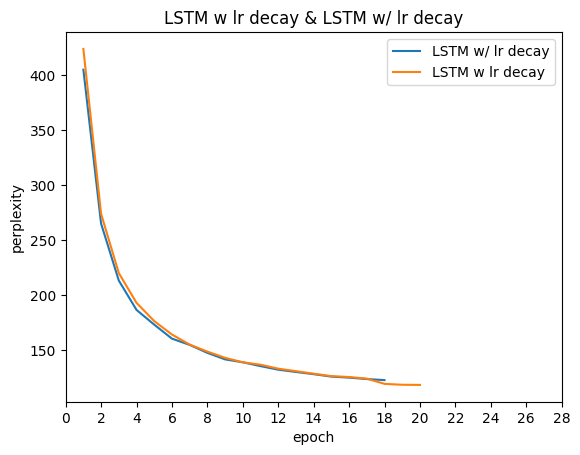

In [26]:
import matplotlib.pyplot as plt
plt.style.use('default')
epoch1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
epoch2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
lstm_ppl = [405.1020335637, 265.0128127048302, 213.2038312381442, 186.49098280603843, 173.0597030767456, 160.32541795335257, 154.64483848671048, 147.39568111369516, 141.44010709954685, 138.791629169947, 135.31633928486795, 132.07127285633078, 129.9902300401168, 127.98433135507605, 125.76271917551085, 124.8436254260244, 123.54427684754972, 122.58228415279412]
lstm_optim_ppl = [423.99938229601577, 273.9013805341435, 220.01740873556275, 192.90912862225318, 176.2954286229031, 164.0766944689151, 154.92732072665484, 148.52270005955293, 142.8686736414221, 138.7858073884758, 136.58185364754897, 133.0029115119872, 130.7065764096995, 128.4270830919314, 126.18930139594973, 125.40046926867802, 123.90896087224232, 119.16365800625233, 118.34357804839952,118.19967075617303]
fig,ax = plt.subplots()
ax.plot(epoch1, lstm_ppl,label = 'LSTM w/ lr decay')
ax.plot(epoch2, lstm_optim_ppl,label = 'LSTM w lr decay')
plt.xlabel('epoch')
plt.ylabel('perplexity')
ax.set_xticks(np.arange(0,30,2))
ax.set_title('LSTM w lr decay & LSTM w/ lr decay')
ax.legend()
plt.show()